<a href="https://colab.research.google.com/github/butchland/fastai_xla_extensions/blob/master/explore_nbs/explore_export_tpu_model_issue_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !curl -s https://course19.fast.ai/setup/colab | bash
# !pip install -Uqq fastai --upgrade
# !pip install -Uqq git+https://github.com/butchland/fastai_xla_extensions.git
# !pip install -Uqq cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp36-cp36m-linux_x86_64.whl

In [ ]:
!pip freeze | grep torch
!pip freeze | grep fast

In [1]:
from fastai.vision.all import *

In [2]:
# import torch_xla.core.xla_model as xm

In [3]:

# import fastai_xla_extensions.core

In [4]:
DEBUG = True

In [5]:
orig_export = Learner.export

In [6]:
#@patch
def export(self:Learner, fname='export.pkl', pickle_protocol=2):
    "Export the content of `self` without the items and the optimizer state for inference"
    orig_model = self.model.to(torch.device('cpu'))
    self.model = orig_model.state_dict() # just check to see if this works
    # if rank_distrib(): return # don't export if child proc
    # self._end_cleanup()
    # old_dbunch = self.dls
    # self.dls = self.dls.new_empty()
    # state = self.opt.state_dict() if self.opt is not None else None
    # self.opt = None
    # with warnings.catch_warnings():
    #     #To avoid the warning that come from PyTorch about model not being checked
    #     warnings.simplefilter("ignore")
    #     torch.save(self, self.path/fname)
    # self.create_opt()
    # if state is not None: self.opt.load_state_dict(state)
    # self.dls = old_dbunch
    orig_export(self, fname=fname, pickle_protocol=pickle_protocol)
    self.model = orig_model

In [7]:
path = untar_data(URLs.MNIST_TINY)
data = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=GrandparentSplitter(),
    item_tfms=Resize(28),
    # batch_tfms=aug_transforms(size=28, do_flip=False)
    batch_tfms=[]
)
dls = data.dataloaders(path, bs=256)
learner = cnn_learner(dls, resnet18, metrics=accuracy)

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.0008317637839354575)

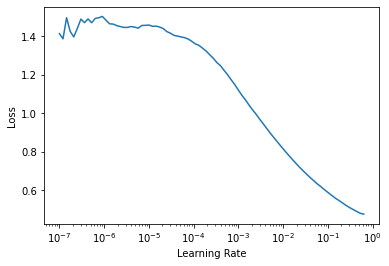

In [8]:
learner.lr_find()

In [9]:
%%time
learner.fine_tune(6, freeze_epochs=4, base_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.218799,0.617819,0.572246,00:02
1,0.964602,0.357047,0.815451,00:02
2,0.746032,0.590406,0.758226,00:04
3,0.619498,0.475106,0.835479,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.140934,0.196375,0.924177,00:02
1,0.102408,0.237294,0.917024,00:02
2,0.082545,0.112995,0.964235,00:02
3,0.075167,0.108766,0.959943,00:02
4,0.060675,0.102879,0.971388,00:02
5,0.051229,0.106496,0.968526,00:02


CPU times: user 3.52 s, sys: 1.98 s, total: 5.5 s
Wall time: 26.1 s


In [10]:
one_param(learner.model).device

device(type='xla', index=1)

In [11]:
learner.save('stage-1')

Path('models/stage-1.pth')

In [12]:
learner2 = cnn_learner(dls, resnet18, metrics=accuracy)

In [13]:
learner2.load('stage-1')

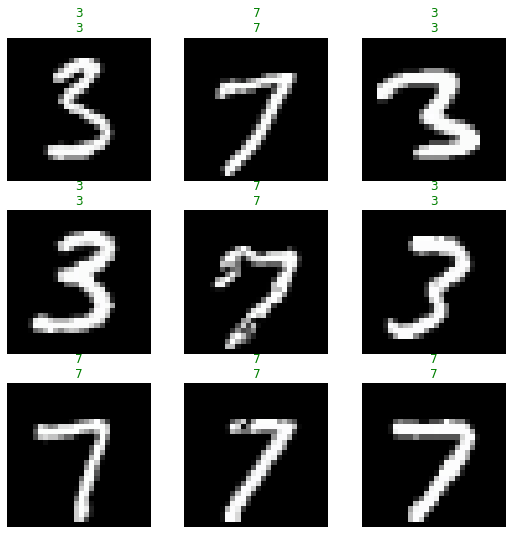

In [14]:
learner2.show_results()

In [15]:
interp = ClassificationInterpretation.from_learner(learner2)

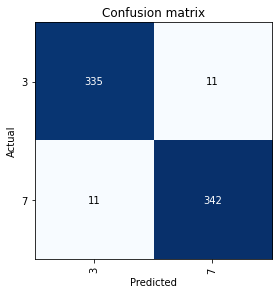

In [16]:
interp.plot_confusion_matrix()

In [17]:
learner3 = cnn_learner(dls, resnet18, metrics=accuracy)

In [18]:
learner3.load('stage-1');

In [19]:
one_param(learner3.model).device

device(type='xla', index=1)

In [20]:
learner3.fit_one_cycle(5,lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.002837,0.112902,0.961373,00:02
1,0.001792,0.116382,0.961373,00:02
2,0.003607,0.119198,0.959943,00:02
3,0.004794,0.121746,0.959943,00:02
4,0.011858,0.125150,0.959943,00:02


In [21]:
learner3.export()

In [2]:
inference_learner = load_learner('export.pkl')

RuntimeError: ignored

In [23]:
one_param(inference_learner.model).device

device(type='xla', index=1)

In [24]:
inference_learner.dls.device

device(type='cpu')

In [25]:
inference_learner.dls.device = one_param(inference_learner.model).device

In [26]:
inference_learner.dls.device

device(type='xla', index=1)

In [27]:
test_items = get_image_files(path/'valid')

In [28]:
len(test_items)

699

In [29]:
test_labels = test_items.map(parent_label)

In [30]:
len(test_labels)

699

In [31]:
test_labels[:5]

(#5) ['3','3','3','3','3']

In [32]:
test_dl = inference_learner.dls.test_dl(test_items,with_labels=True)

In [33]:
preds, targs, dec_preds = learner2.get_preds(dl=test_dl, with_decoded=True)

In [34]:
accuracy(preds, targs)

TensorCategory(0.9685)

In [35]:
accuracy(preds, dec_preds)

tensor(1.)

In [36]:
one_param(learner.model).device

device(type='xla', index=1)

In [37]:
# model_state = learner.model.state_dict()

In [38]:
# learner.model.to(torch.device('cpu'))
# one_param(learner.model).device

In [39]:
# one_param(learner.model).device